<a href="https://colab.research.google.com/github/BeaEsparcia/Spanish_News_Classification/blob/main/Spanish_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to classify news articles into different categories using Natural Language Processing (NLP) techniques and machine learning algorithms. The model is trained to recognize six main categories: Culture, Sports, Economy, Spain, International, and Society. It leverages feature extraction techniques such as TF-IDF and machine learning models like Logistic Regression and Random Forest to achieve high accuracy.

Install required dependencies and import libraries

In [1]:
# Install required dependencies
!pip install nltk seaborn  # Seaborn already includes Matplotlib

# Import required libraries
import pandas as pd  # Data handling
import string  # String manipulation

# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer  # Text vectorization

# Import Machine Learning libraries
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.linear_model import LogisticRegression  # ML model
from sklearn.ensemble import RandomForestClassifier  # ML model
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation metrics

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt  # Required for Seaborn plots

# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Load dataset

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/BeaEsparcia/Clasificacion_Noticias/main/dataset_noticias.csv'
df_news = pd.read_csv(url)

# Check the first rows to verify the data
print("Dataset loaded successfully. First rows:")
df_news.head()

Dataset loaded successfully. First rows:


,TÍTULO,FECHA,AUTOR,CONTENIDO,CATEGORÍA
0,La NASA ha pedido a SpaceX que construya una n...,2024-06-26T23:17:12Z,Matías S. Zavia,La NASA ha seleccionado a SpaceX para la noble...,Internacional
1,La situación del traje espacial de la ISS de l...,2024-06-26T17:25:00Z,Passant Rabie,Dos astronautas de la NASA se estaban preparan...,Internacional
2,Prefijo +39 en WhatsApp y llamadas: ten cuidad...,2024-06-26T18:36:42Z,Marcos Merino,"En los últimos meses, ha habido un notable inc...",Internacional
3,Collins Aerospace se retira del contrato para ...,2024-06-26T09:27:58Z,wicho@microsiervos.com (Wicho),Por @Wicho 26 de Junio de 2024\r\nEn junio de ...,Internacional
4,Tanques y militares armados toman la sede del ...,2024-06-26T20:16:50Z,Agencias,Varios tanques y militares fuertemente armados...,Internacional


Preprocess text data

In [3]:
# Define preprocessing: set stopwords and stemmer
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

def preprocess_text(text):
    """Clean and preprocess text by:
    - Converting to lowercase
    - Removing punctuation
    - Tokenizing
    - Removing stopwords
    - Applying stemming
    """
    if pd.isnull(text):  # Handle NaN values
        return ''

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize text
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Remove stopwords & apply stemming
    return ' '.join(tokens)

# Remove NaNs in 'CONTENIDO' and 'CATEGORÍA' before processing
df_news.dropna(subset=['CONTENIDO', 'CATEGORÍA'], inplace=True)

# Fill NaNs in 'AUTOR' with "Desconocido"
df_news['AUTOR'].fillna('Desconocido', inplace=True)

# Apply text preprocessing
df_news['cleaned_text'] = df_news['CONTENIDO'].apply(preprocess_text)

# Show first rows after preprocessing
print("First rows of the DataFrame after preprocessing:")
print(df_news.head())

# Check NaN values after processing
print("\nNaN count after handling:")
print(df_news.isnull().sum())

<ipython-input-3-d69f3485a2f2>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_news['AUTOR'].fillna('Desconocido', inplace=True)


First rows of the DataFrame after preprocessing:
                                              TÍTULO                 FECHA  \
0  La NASA ha pedido a SpaceX que construya una n...  2024-06-26T23:17:12Z   
1  La situación del traje espacial de la ISS de l...  2024-06-26T17:25:00Z   
2  Prefijo +39 en WhatsApp y llamadas: ten cuidad...  2024-06-26T18:36:42Z   
3  Collins Aerospace se retira del contrato para ...  2024-06-26T09:27:58Z   
4  Tanques y militares armados toman la sede del ...  2024-06-26T20:16:50Z   

                            AUTOR  \
0                 Matías S. Zavia   
1                   Passant Rabie   
2                   Marcos Merino   
3  wicho@microsiervos.com (Wicho)   
4                        Agencias   

                                           CONTENIDO      CATEGORÍA  \
0  La NASA ha seleccionado a SpaceX para la noble...  Internacional   
1  Dos astronautas de la NASA se estaban preparan...  Internacional   
2  En los últimos meses, ha habido un notable 

Vectorize text using TF-IDF

In [4]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary to top 5000 words
X = vectorizer.fit_transform(df_news['cleaned_text'])
y = df_news['CATEGORÍA']

# Print the shape of the TF-IDF matrix to verify the transformation
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (5773, 5000)


 Split the dataset

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train classification models

In [6]:
# Train Logistic Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)  # Ensure reproducibility
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluate model performance

In [7]:
# Evaluate models
print("\nModel Evaluation:")
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

print("\nLogistic Regression Results:\n", classification_report(y_test, y_pred_lr))


Model Evaluation:

Logistic Regression Results:
                precision    recall  f1-score   support

      Cultura       0.35      0.39      0.37       198
     Deportes       0.60      0.42      0.49       173
     Economía       0.57      0.59      0.58       198
       España       0.47      0.50      0.48       192
Internacional       0.51      0.47      0.49       213
     Sociedad       0.38      0.43      0.40       181

     accuracy                           0.47      1155
    macro avg       0.48      0.47      0.47      1155
 weighted avg       0.48      0.47      0.47      1155



Visualize confusion matrices

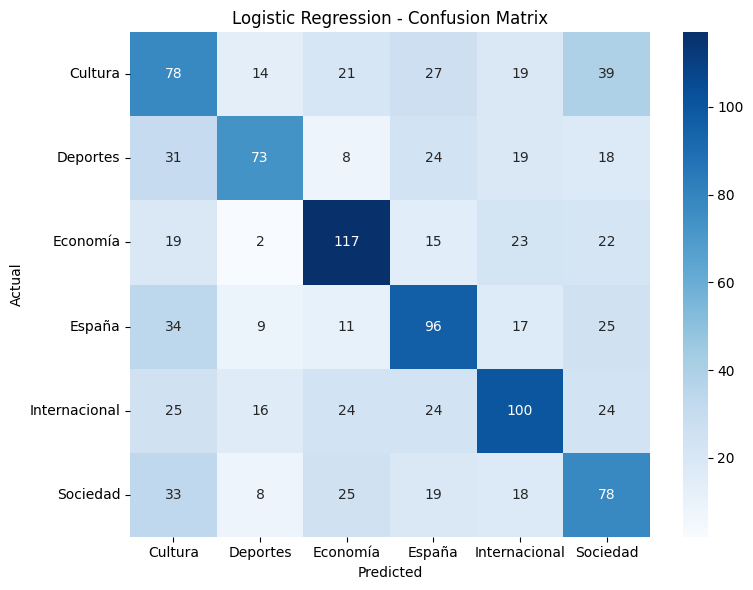

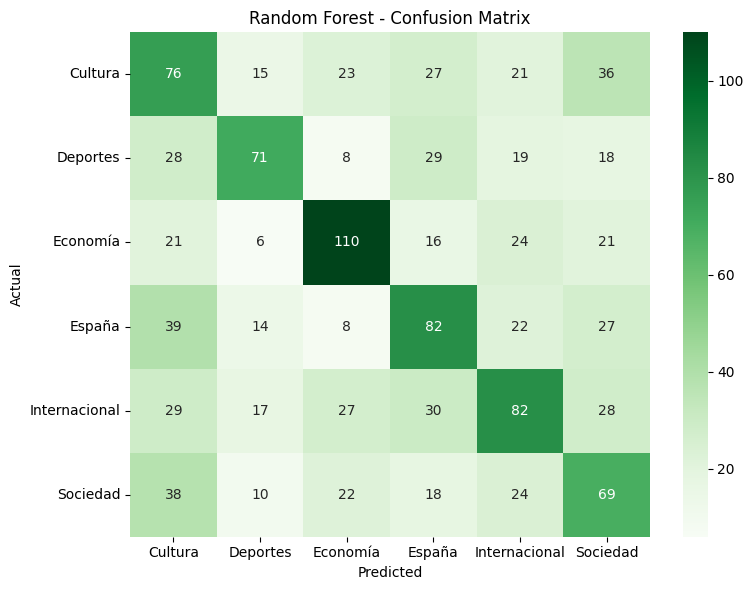

In [8]:
import numpy as np

# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression", cmap='Blues')
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest", cmap='Greens')